# 1.30f: Bulk vs. Thermal Motion

**Purpose:** Separate the dead token cloud's motion into two components:
1. **Bulk motion:** Drift of the center of mass (centroid trajectory)
2. **Thermal motion:** Internal jitter relative to the center of mass

## Context

In 1.30e, we saw chaotic noise in the 500-2000 step range when computing total system displacement. Hypothesis: we're conflating two different physical processes—bulk drift of the whole cloud vs. internal thermal motion.

By centering the cloud at each timestep, we can analyze these separately.

## Random Walk Hypothesis

**Prediction:** The centroid will follow a **biased random walk** in 64D:
- Unbiased random walk: `E[||R||] ∝ √(N × D)` where N = steps, D = dimensions
- Biased walk: `||R|| ≈ N × ||bias|| + √N × noise`

Since we have exact measurements (no uncertainty), we can:
1. Compute the bias vector exactly: `bias = (centroid[final] - centroid[0]) / N`
2. Subtract linear trend: `residual[t] = centroid[t] - (centroid[0] + t × bias)`
3. Test if residuals scale as √t (signature of unbiased random walk)
4. Quantify bias strength vs. noise

Let's science this shit.

## Parameters

In [1]:
# Data path
DATA_PATH = "../tensors/Thimble/thimble_6.h5"

# Plot settings
DPI = 200
FIGSIZE = (12, 6)

print("✓ Parameters set")

✓ Parameters set


## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import h5py
from pathlib import Path

print("✓ Imports complete")

✓ Imports complete


## Load Data

In [3]:
print(f"Loading dead token trajectories from {DATA_PATH}...\n")

with h5py.File(DATA_PATH, 'r') as f:
    # Load metadata
    n_steps = f.attrs['num_steps']
    dead_mask = torch.from_numpy(f['dead_mask'][:]).bool()
    n_dead = dead_mask.sum().item()
    
    # Load dead token trajectories
    print(f"Loading W[:, dead_mask, :] ... ({n_steps+1} × {n_dead} × 64)")
    W_dead_bf16 = torch.from_numpy(f['W'][:, dead_mask, :]).to(torch.bfloat16)
    W_dead = W_dead_bf16.float()

print(f"\n✓ Data loaded: {tuple(W_dead.shape)}")
print(f"Dead tokens: {n_dead}")

Loading dead token trajectories from ../tensors/Thimble/thimble_6.h5...

Loading W[:, dead_mask, :] ... (6001 × 3699 × 64)

✓ Data loaded: (6001, 3699, 64)
Dead tokens: 3699


## Step 1: Compute Centroid Trajectory (Bulk Motion)

In [4]:
print("Computing centroid trajectory...\n")

# Centroid at each timestep: mean across tokens (dim=1)
centroid = W_dead.mean(dim=1)  # shape: (6001, 64)

# Centroid displacement vectors (step-to-step)
centroid_displacement = centroid[1:] - centroid[:-1]  # (6000, 64)

# Centroid displacement magnitude (L2 norm)
centroid_step_size = torch.norm(centroid_displacement, dim=1)  # (6000,)

# Total centroid displacement from origin
centroid_from_origin = torch.norm(centroid - centroid[0], dim=1)  # (6001,)

print(f"Centroid shape: {tuple(centroid.shape)}")
print(f"Centroid step size: {tuple(centroid_step_size.shape)}")
print(f"Centroid displacement from origin: {tuple(centroid_from_origin.shape)}")
print(f"\n✓ Centroid trajectory computed")

Computing centroid trajectory...

Centroid shape: (6001, 64)
Centroid step size: (6000,)
Centroid displacement from origin: (6001,)

✓ Centroid trajectory computed


## Step 2: Center the Cloud (Remove Bulk Motion)

In [5]:
print("Centering the cloud...\n")

# Subtract centroid from all tokens at each timestep
W_centered = W_dead - centroid.unsqueeze(1)  # Broadcasting: (6001, 3699, 64)

# Verify centering worked (centroid of centered cloud should be ~zero)
verification = W_centered.mean(dim=1).abs().max().item()

print(f"Centered cloud shape: {tuple(W_centered.shape)}")
print(f"Max centroid component after centering: {verification:.2e}")
print(f"  (should be ~machine epsilon for float32: ~1e-7)")
print(f"\n✓ Cloud centered")

Centering the cloud...

Centered cloud shape: (6001, 3699, 64)
Max centroid component after centering: 1.49e-08
  (should be ~machine epsilon for float32: ~1e-7)

✓ Cloud centered


## Step 3: Compute Thermal Motion (in Centered Frame)

In [6]:
print("Computing thermal motion metrics...\n")

# Displacement vectors in centered frame
dW_centered = W_centered[1:] - W_centered[:-1]  # (6000, 3699, 64)

# Per-token displacement magnitude
thermal_displacement_L2 = torch.norm(dW_centered, dim=2)  # (6000, 3699)

# System-wide thermal quantities
total_thermal_L2 = thermal_displacement_L2.sum(dim=1)  # (6000,)
thermal_KE_analog = 0.5 * (thermal_displacement_L2 ** 2).sum(dim=1)  # (6000,)
max_thermal_displacement = thermal_displacement_L2.max(dim=1)[0]  # (6000,)
n_moving = (thermal_displacement_L2 > 0).sum(dim=1).float()  # (6000,)

print(f"Thermal displacements: {tuple(dW_centered.shape)}")
print(f"Total thermal L2: {tuple(total_thermal_L2.shape)}")
print(f"\n✓ Thermal motion computed")

Computing thermal motion metrics...

Thermal displacements: (6000, 3699, 64)
Total thermal L2: (6000,)

✓ Thermal motion computed


## Random Walk Analysis: Compute Bias Vector

In [7]:
print("Analyzing centroid random walk...\n")

# Total displacement vector
total_displacement_vector = centroid[-1] - centroid[0]  # (64,)
total_displacement_magnitude = torch.norm(total_displacement_vector).item()

# Bias vector (mean displacement per step)
bias_vector = total_displacement_vector / n_steps  # (64,)
bias_magnitude = torch.norm(bias_vector).item()

# Construct linear trend (what we'd expect from pure bias)
t = torch.arange(n_steps + 1, dtype=torch.float32)  # (6001,)
linear_trend = centroid[0].unsqueeze(0) + t.unsqueeze(1) * bias_vector.unsqueeze(0)  # (6001, 64)

# Residuals (deviations from linear trend)
residuals = centroid - linear_trend  # (6001, 64)
residual_magnitude = torch.norm(residuals, dim=1)  # (6001,)

print(f"Total centroid displacement: {total_displacement_magnitude:.6f} units")
print(f"Bias magnitude per step: {bias_magnitude:.6e} units/step")
print(f"Bias direction (first 5 components): {bias_vector[:5].numpy()}")
print(f"\nResidual magnitude (final): {residual_magnitude[-1].item():.6f} units")
print(f"\n✓ Bias analysis complete")

Analyzing centroid random walk...

Total centroid displacement: 0.701211 units
Bias magnitude per step: 1.168685e-04 units/step
Bias direction (first 5 components): [-1.11253039e-05  8.97104837e-06 -1.12239031e-05  1.12412936e-05
  1.10662795e-05]

Residual magnitude (final): 0.000000 units

✓ Bias analysis complete


## Random Walk Analysis: Expected vs Actual Scaling

In [8]:
print("Testing random walk scaling hypothesis...\n")

# For unbiased random walk in D dimensions:
# E[||R||] ≈ s × sqrt(N × D)
# where s = typical step size

D = 64
typical_step_size = centroid_step_size[centroid_step_size > 0].median().item()

# Expected displacement for unbiased walk
expected_unbiased = typical_step_size * np.sqrt(n_steps * D)

# Expected displacement from bias alone
expected_from_bias = bias_magnitude * n_steps

# Bias-to-noise ratio
bias_to_noise = expected_from_bias / expected_unbiased if expected_unbiased > 0 else 0

print(f"Dimensions: D = {D}")
print(f"Steps: N = {n_steps}")
print(f"Typical step size (median): {typical_step_size:.6e} units\n")

print(f"Expected displacement (unbiased random walk): {expected_unbiased:.6f} units")
print(f"Expected displacement (pure bias, no noise): {expected_from_bias:.6f} units")
print(f"Actual displacement: {total_displacement_magnitude:.6f} units\n")

print(f"Bias-to-noise ratio: {bias_to_noise:.2f}")
if bias_to_noise > 2:
    print("  → Bias dominates (directed drift, not diffusion)")
elif bias_to_noise > 0.5:
    print("  → Bias and noise comparable (biased random walk)")
else:
    print("  → Noise dominates (nearly unbiased diffusion)")

print(f"\n✓ Scaling analysis complete")

Testing random walk scaling hypothesis...

Dimensions: D = 64
Steps: N = 6000
Typical step size (median): 3.194245e-05 units

Expected displacement (unbiased random walk): 0.019794 units
Expected displacement (pure bias, no noise): 0.701211 units
Actual displacement: 0.701211 units

Bias-to-noise ratio: 35.43
  → Bias dominates (directed drift, not diffusion)

✓ Scaling analysis complete


## Plot 1: Centroid Displacement from Origin (Bulk Motion)

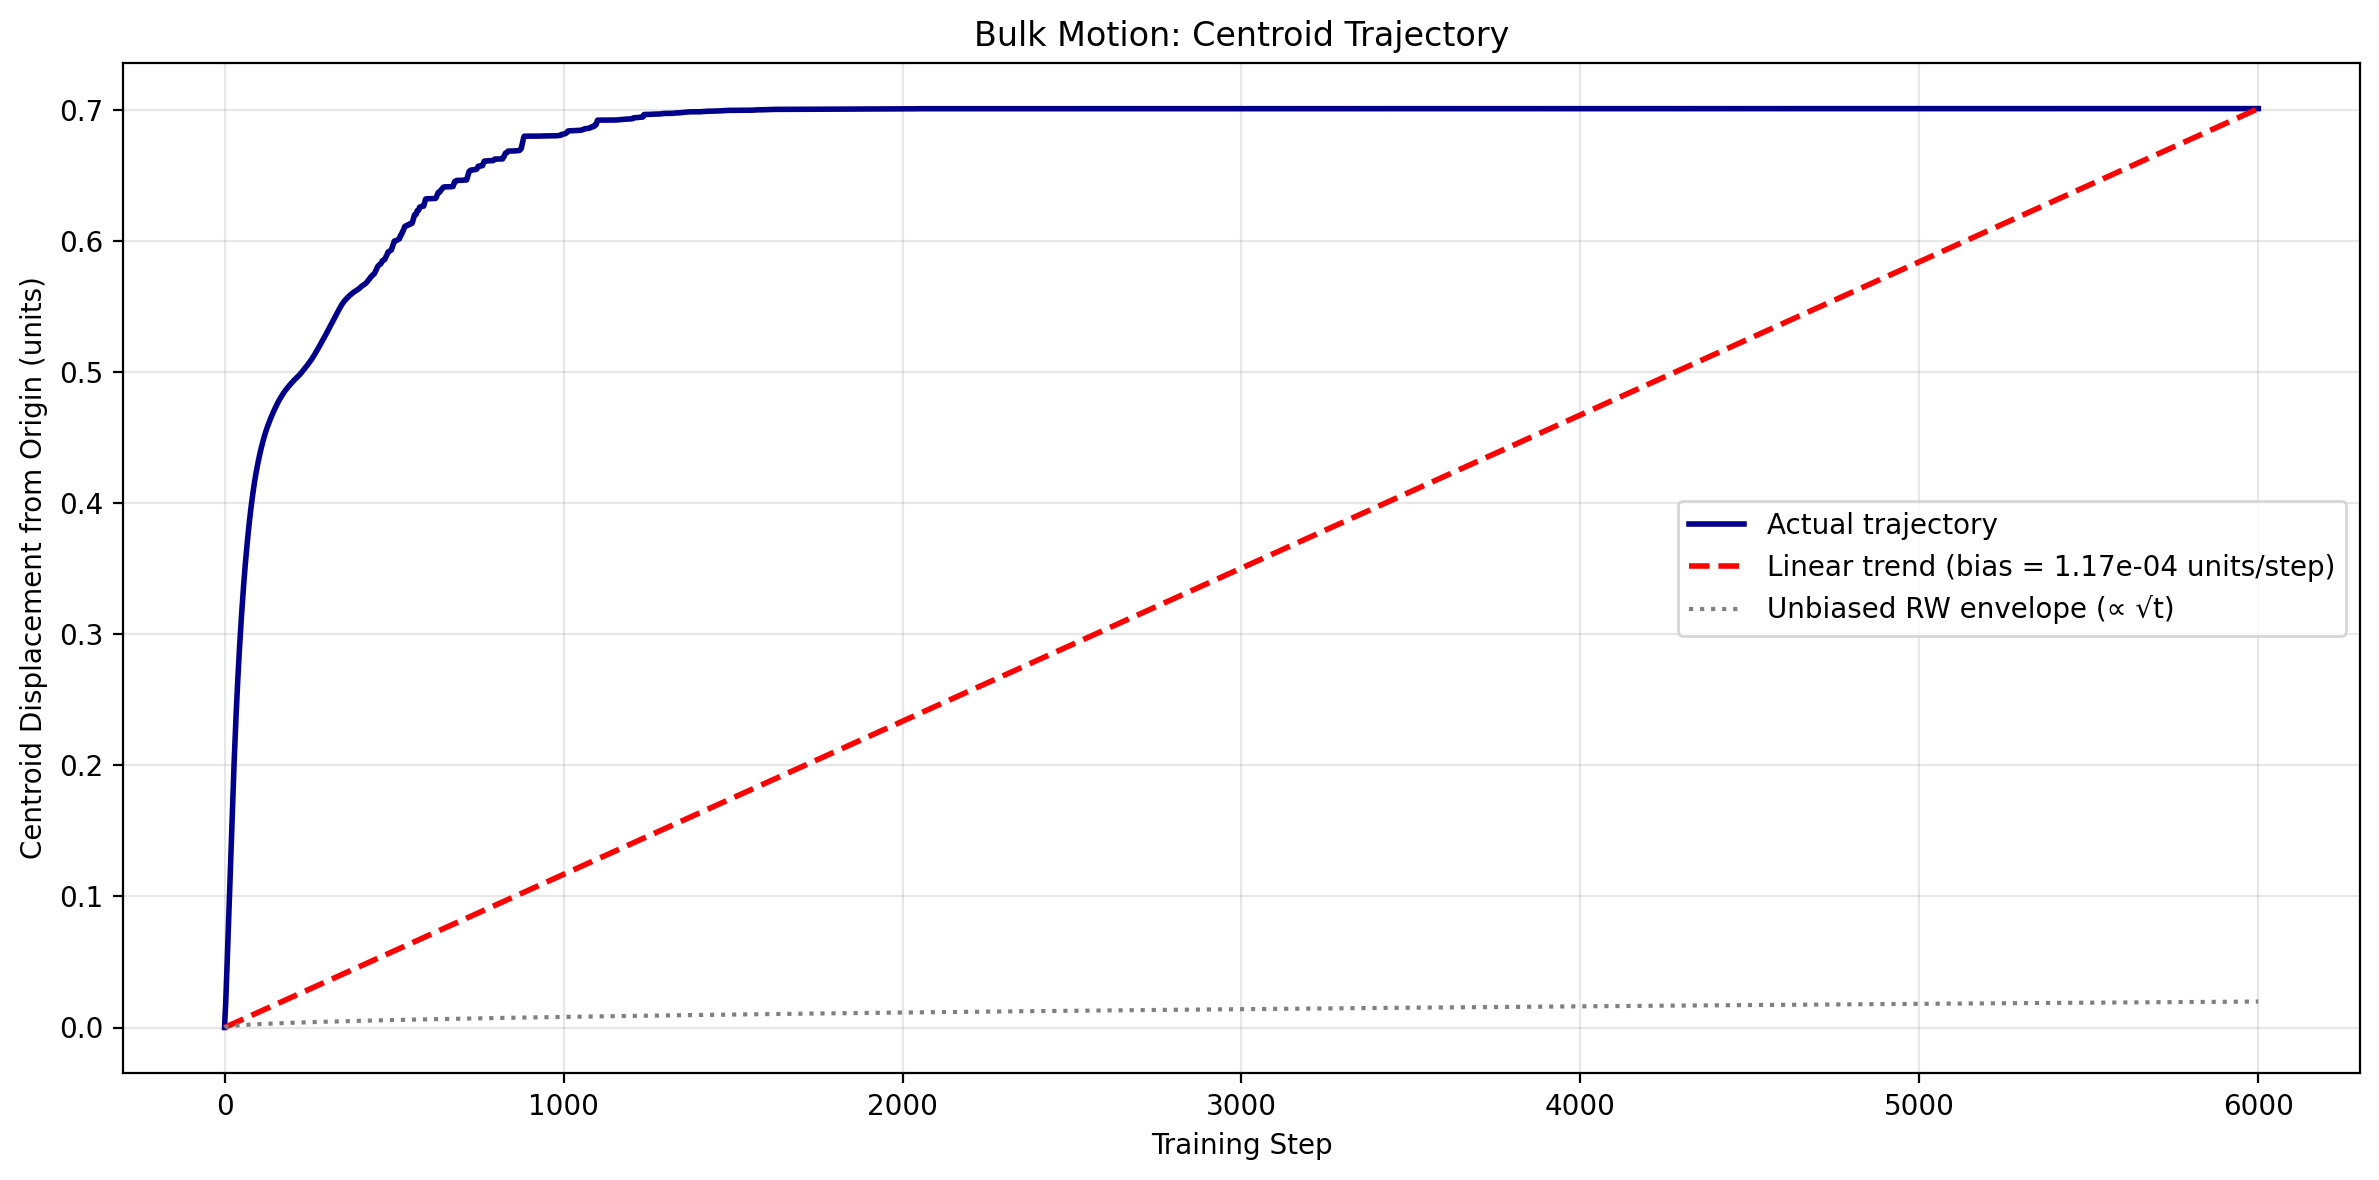


Interpretation: How far the center of mass has drifted from its initial position.
  Linear trend → biased random walk
  √t scaling → unbiased diffusion


In [9]:
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

ax.plot(centroid_from_origin.numpy(), linewidth=2, color='darkblue', label='Actual trajectory')

# Overlay linear trend (pure bias)
linear_prediction = t * bias_magnitude
ax.plot(linear_prediction.numpy(), linewidth=2, linestyle='--', color='red', 
        label=f'Linear trend (bias = {bias_magnitude:.2e} units/step)')

# Overlay expected unbiased random walk envelope
unbiased_envelope = typical_step_size * np.sqrt(t.numpy() * D)
ax.plot(unbiased_envelope, linewidth=1.5, linestyle=':', color='gray',
        label=f'Unbiased RW envelope (∝ √t)')

ax.set_xlabel('Training Step')
ax.set_ylabel('Centroid Displacement from Origin (units)')
ax.set_title('Bulk Motion: Centroid Trajectory')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretation: How far the center of mass has drifted from its initial position.")
print("  Linear trend → biased random walk")
print("  √t scaling → unbiased diffusion")

## Plot 2: Centroid Step Size (Bulk Motion Speed)

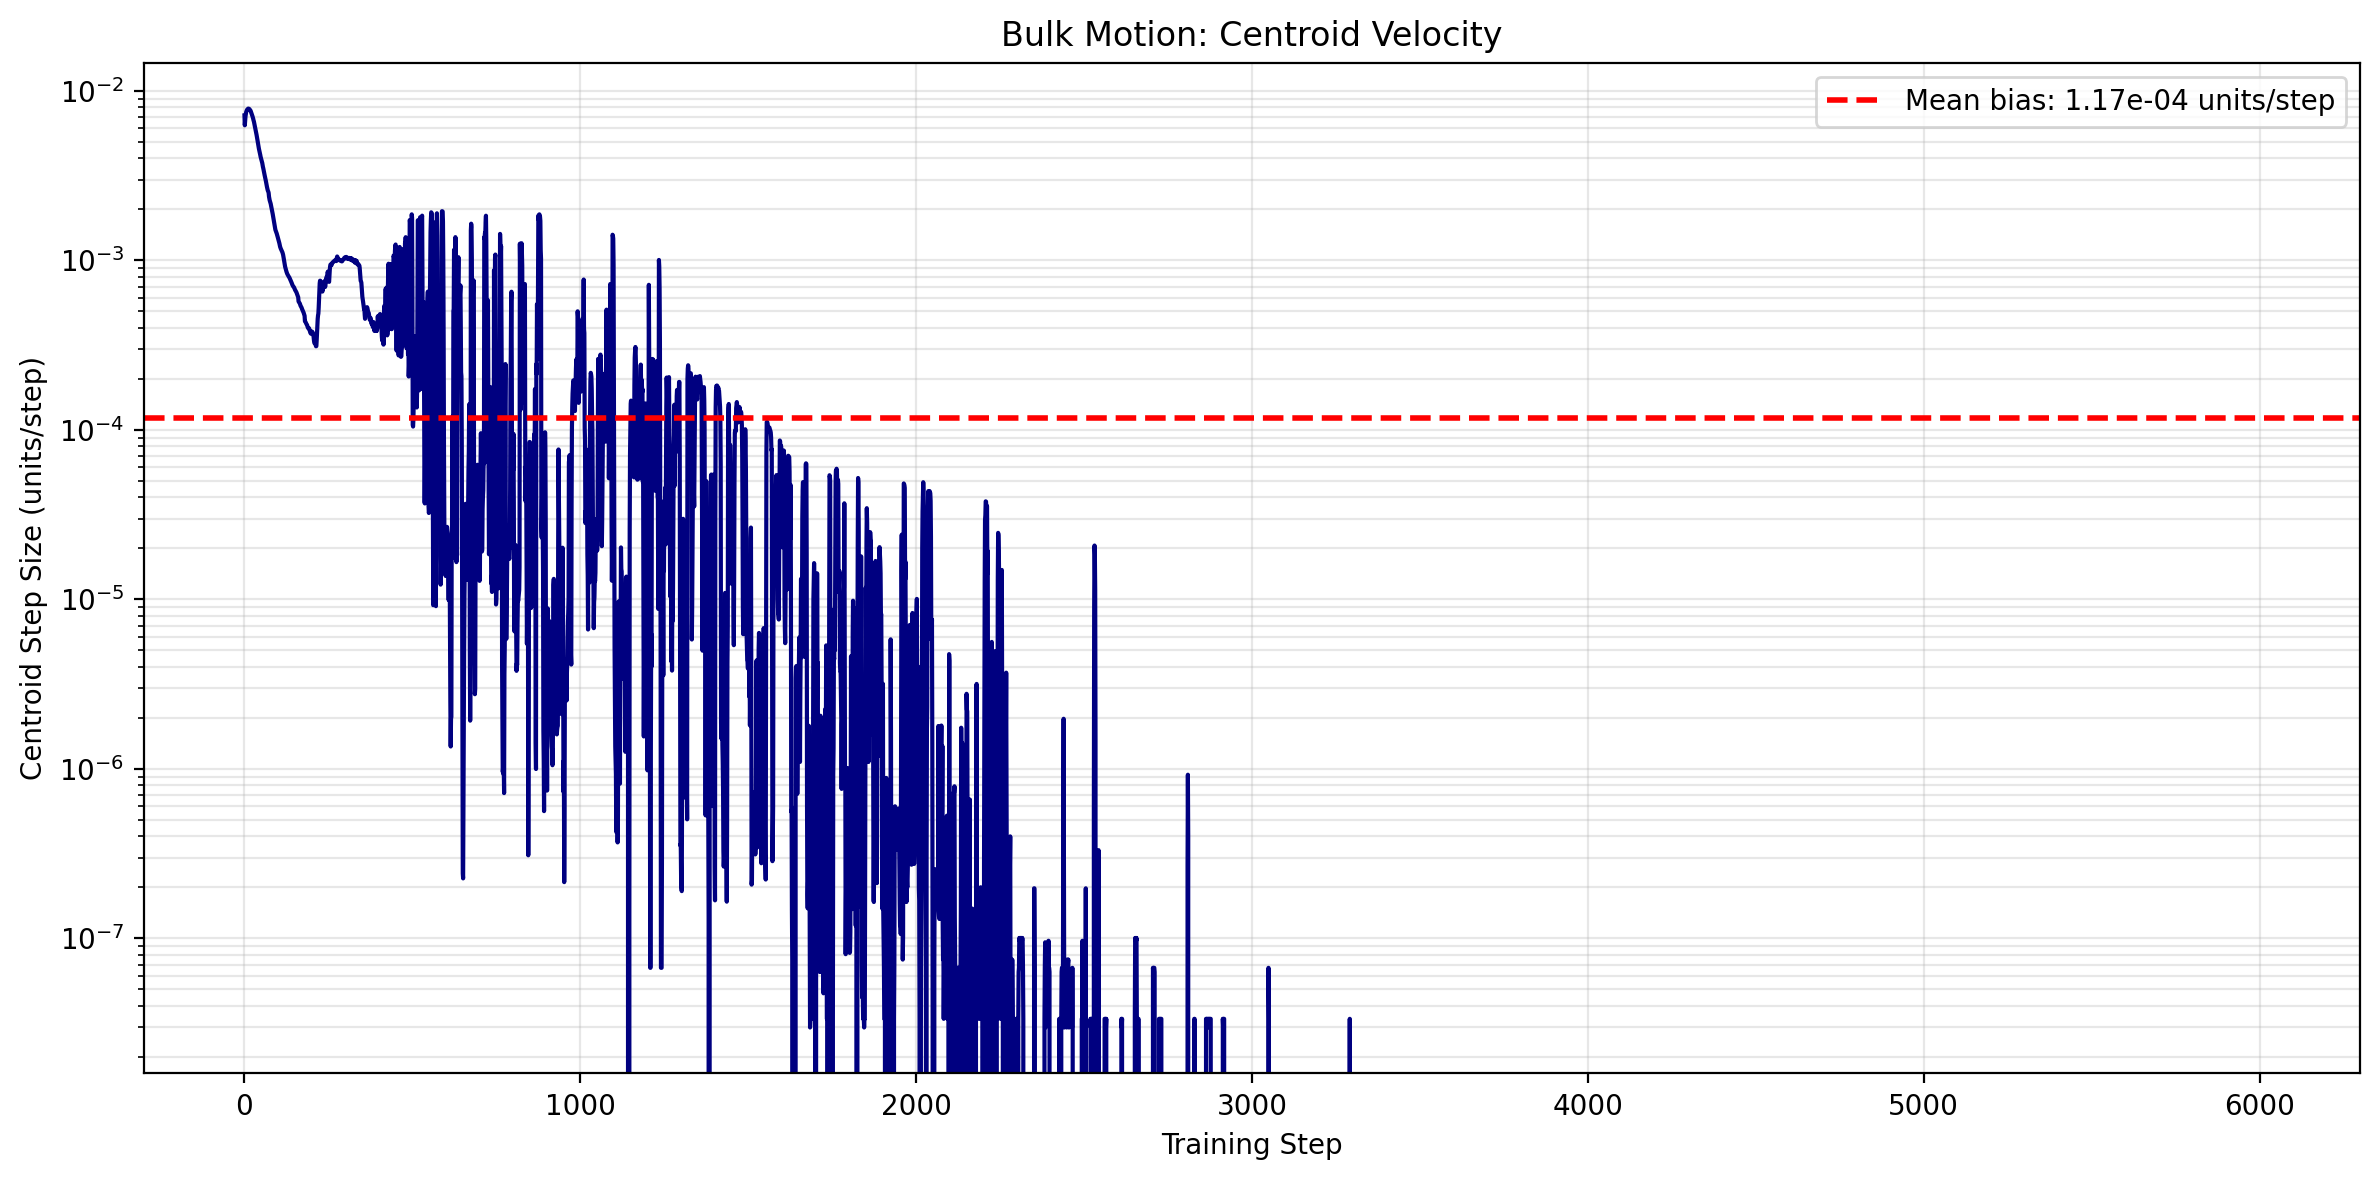


Interpretation: How much the centroid moves at each step.
  Fluctuates around bias → biased random walk
  Decays to zero → system freezing, centroid stops drifting


In [10]:
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

ax.plot(centroid_step_size.numpy(), linewidth=1.5, color='navy')
ax.axhline(bias_magnitude, color='red', linestyle='--', linewidth=2, 
           label=f'Mean bias: {bias_magnitude:.2e} units/step')

ax.set_xlabel('Training Step')
ax.set_ylabel('Centroid Step Size (units/step)')
ax.set_title('Bulk Motion: Centroid Velocity')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print("\nInterpretation: How much the centroid moves at each step.")
print("  Fluctuates around bias → biased random walk")
print("  Decays to zero → system freezing, centroid stops drifting")

## Plot 3: Residuals After Detrending

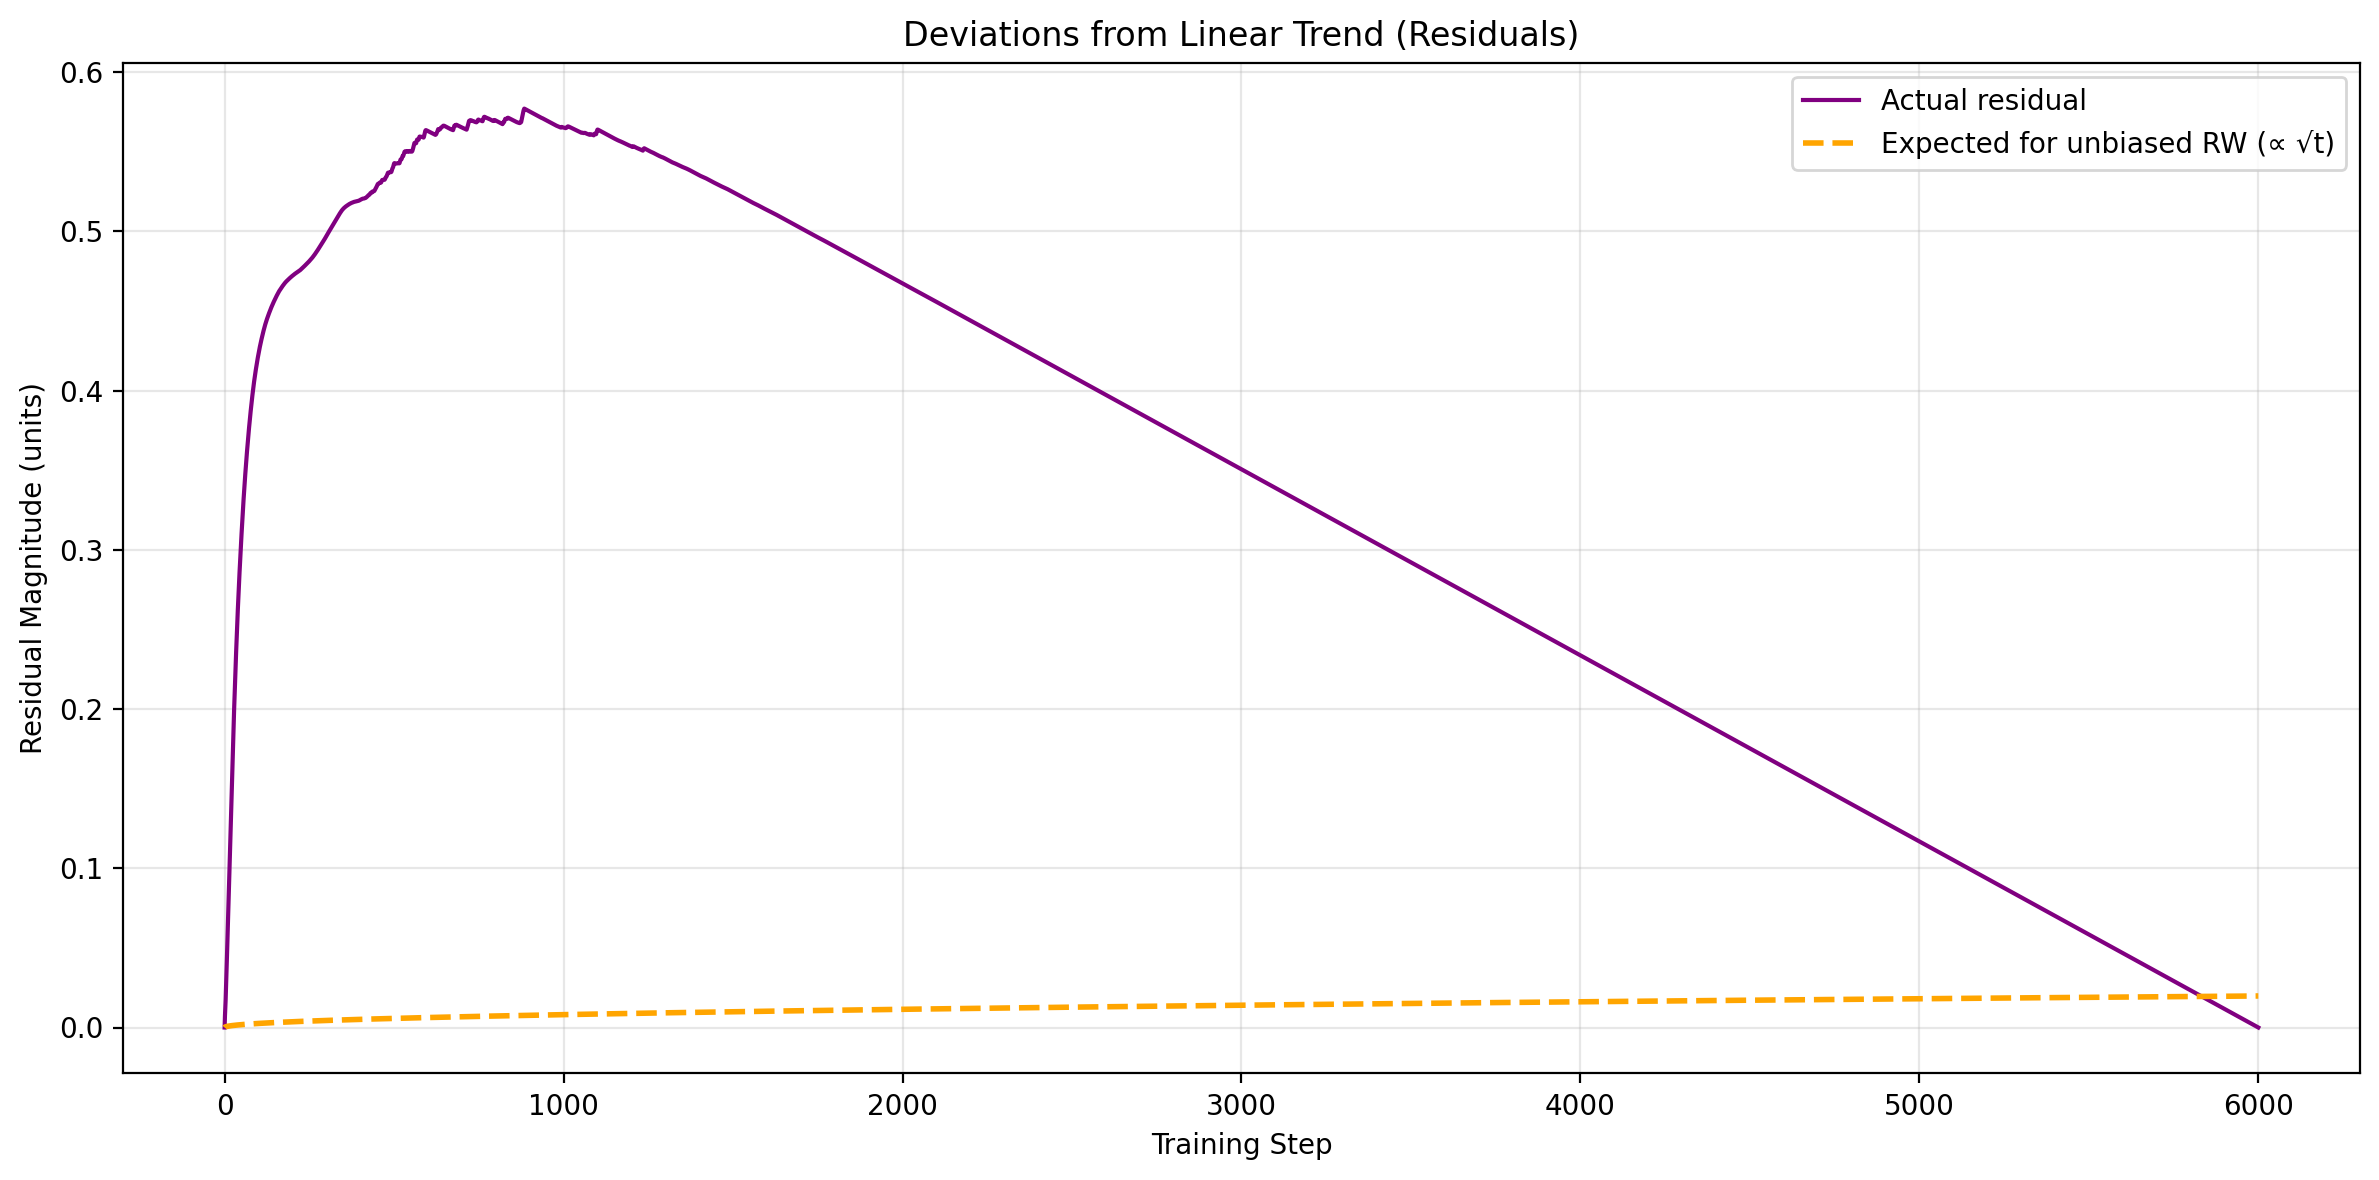


Interpretation: After removing the bias, do residuals look like unbiased diffusion?
  Follows √t → yes, noise component is diffusive
  Deviates from √t → more complex dynamics


In [11]:
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

ax.plot(residual_magnitude.numpy(), linewidth=1.5, color='purple', label='Actual residual')

# Expected √t scaling for unbiased random walk
sqrt_t_prediction = typical_step_size * np.sqrt(t.numpy() * D)
ax.plot(sqrt_t_prediction, linewidth=2, linestyle='--', color='orange',
        label='Expected for unbiased RW (∝ √t)')

ax.set_xlabel('Training Step')
ax.set_ylabel('Residual Magnitude (units)')
ax.set_title('Deviations from Linear Trend (Residuals)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretation: After removing the bias, do residuals look like unbiased diffusion?")
print("  Follows √t → yes, noise component is diffusive")
print("  Deviates from √t → more complex dynamics")

## Plot 4: Total Thermal Motion (Centered Frame)

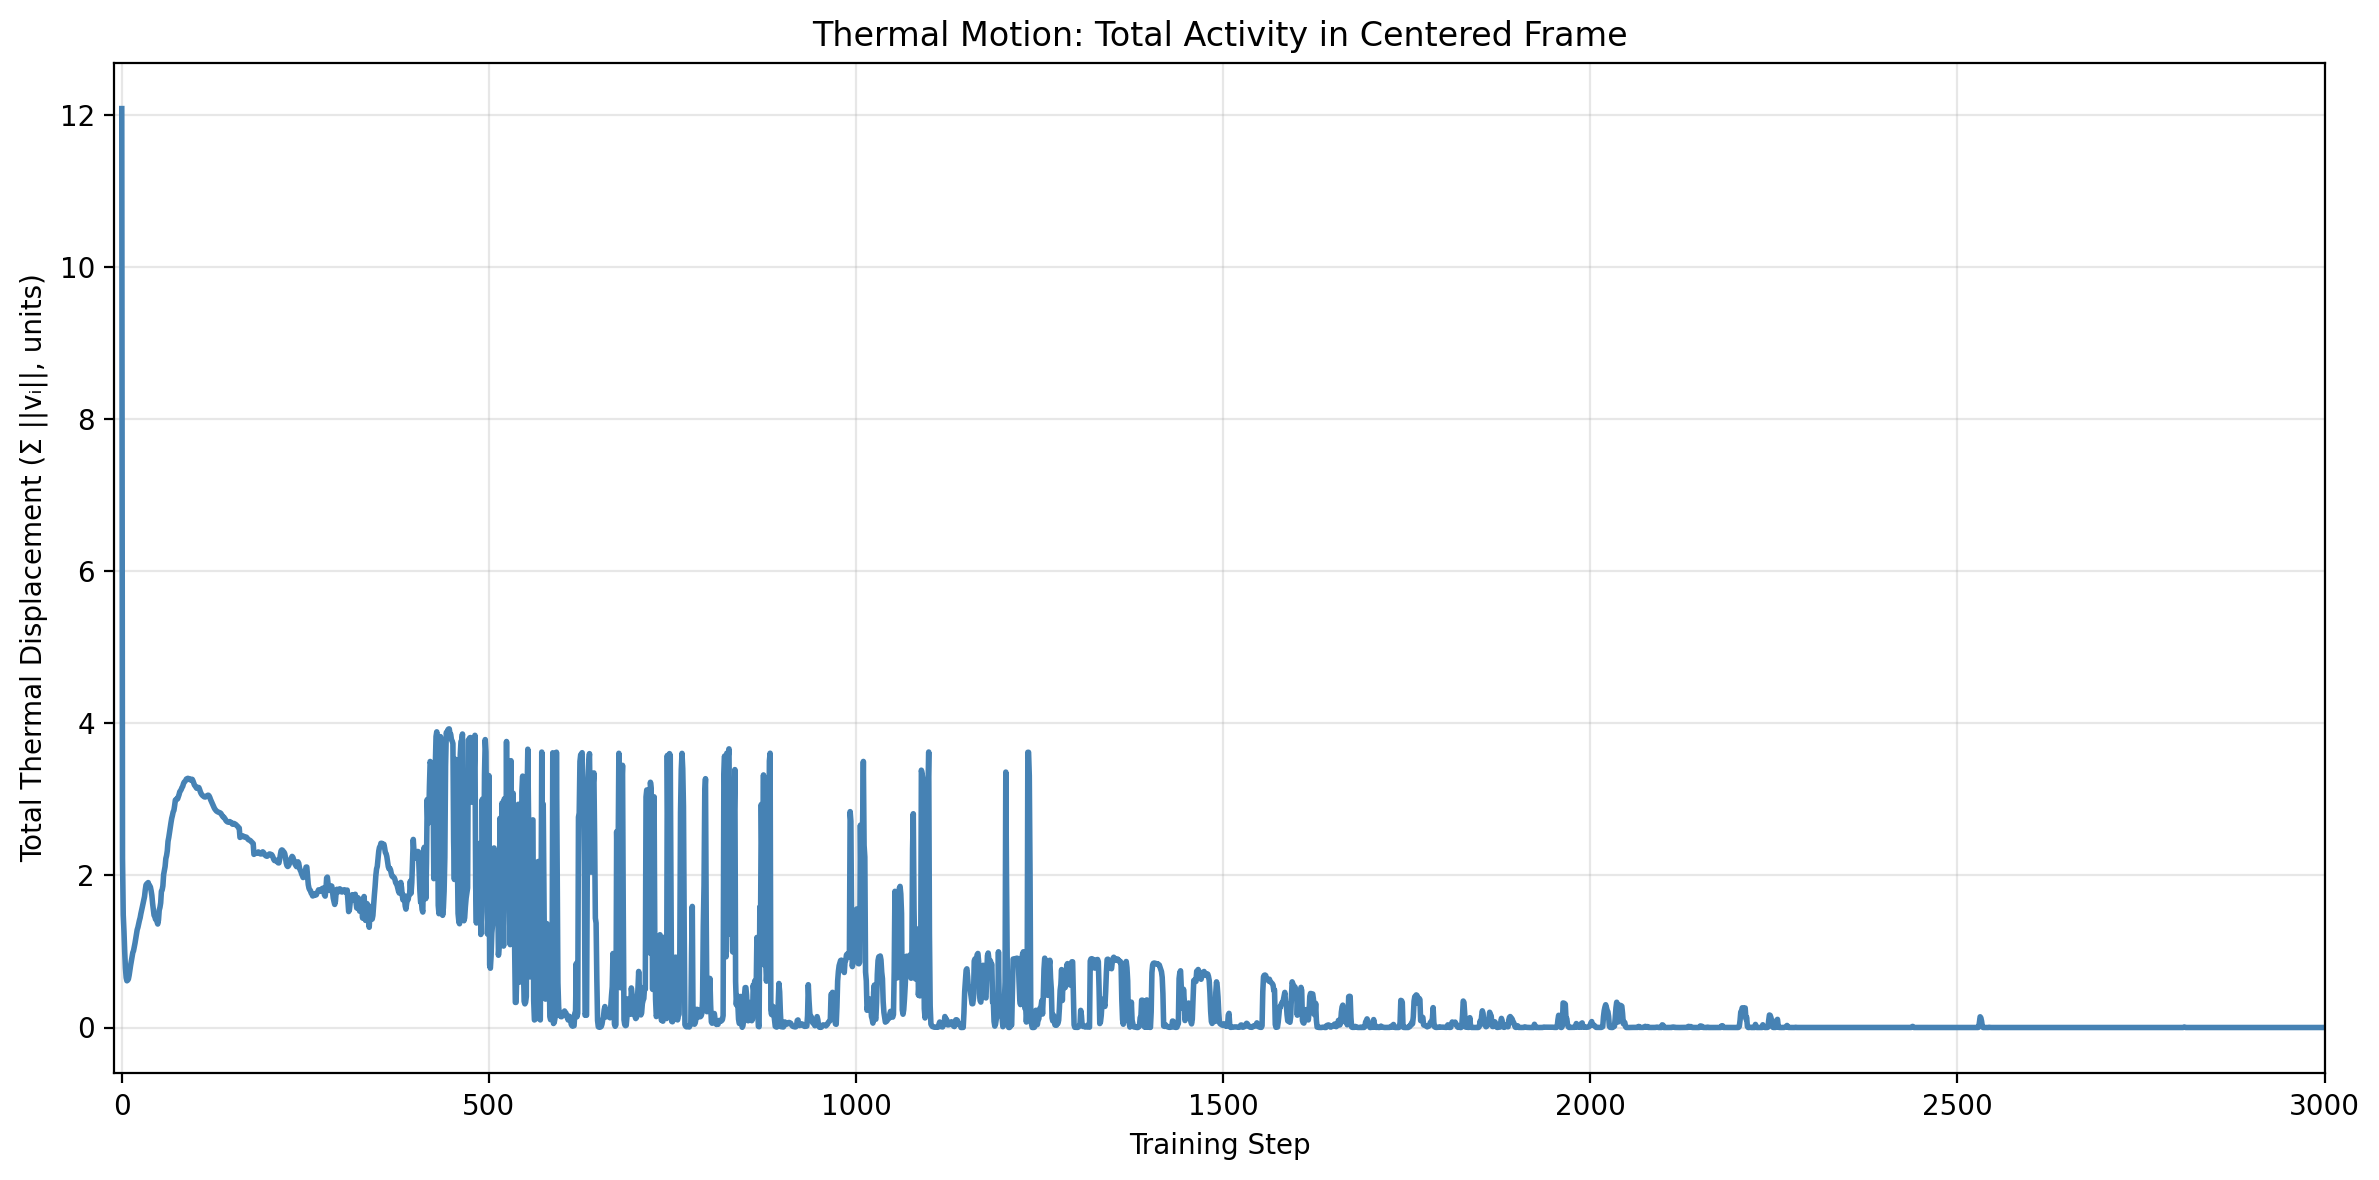


Interpretation: Total motion relative to center of mass (internal jitter).
  Should be cleaner than 1.30e—we've factored out bulk drift.


In [19]:
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

ax.plot(total_thermal_L2.numpy(), linewidth=2, color='steelblue')

ax.set_xlabel('Training Step')
ax.set_ylabel('Total Thermal Displacement (Σ ||vᵢ||, units)')
ax.set_title('Thermal Motion: Total Activity in Centered Frame')
ax.set_yscale('linear')
ax.grid(True, alpha=0.3)
ax.set_xbound(lower=-10, upper=3000)

plt.tight_layout()
plt.show()

print("\nInterpretation: Total motion relative to center of mass (internal jitter).")
print("  Should be cleaner than 1.30e—we've factored out bulk drift.")

## Plot 5: Thermal KE Analog (Centered Frame)

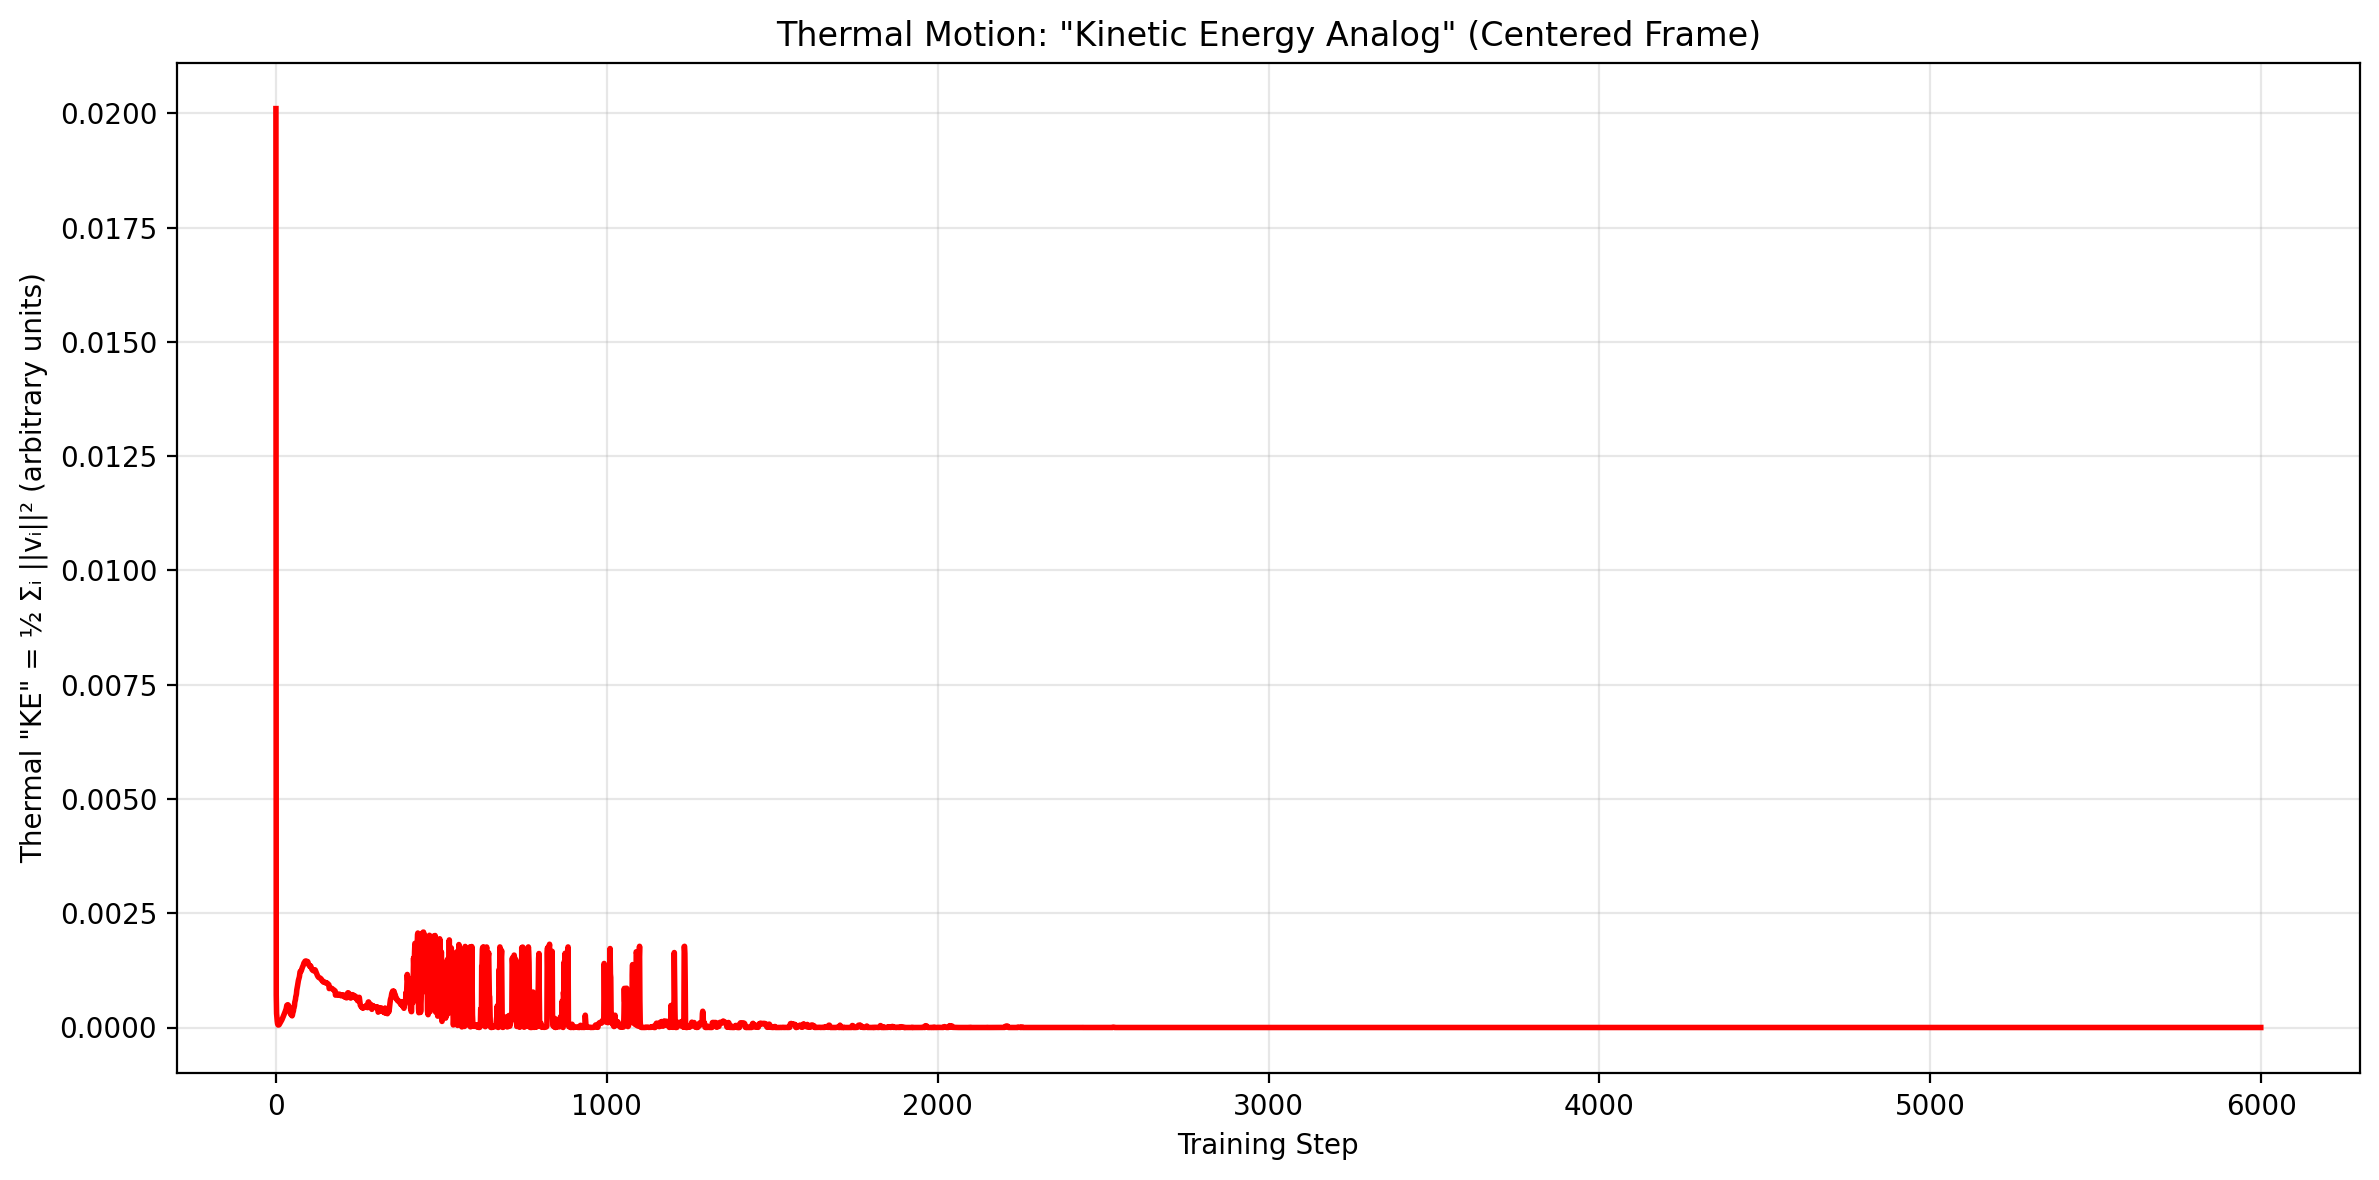


Interpretation: Quadratic measure of thermal motion.
  Emphasizes large hops. Cleaner decay → uniform cooling.


In [13]:
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

ax.plot(thermal_KE_analog.numpy(), linewidth=2, color='red')

ax.set_xlabel('Training Step')
ax.set_ylabel('Thermal "KE" = ½ Σᵢ ||vᵢ||² (arbitrary units)')
ax.set_title('Thermal Motion: "Kinetic Energy Analog" (Centered Frame)')
ax.set_yscale('linear')
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print("\nInterpretation: Quadratic measure of thermal motion.")
print("  Emphasizes large hops. Cleaner decay → uniform cooling.")

## Plot 6: Max Thermal Displacement (Hottest Token)

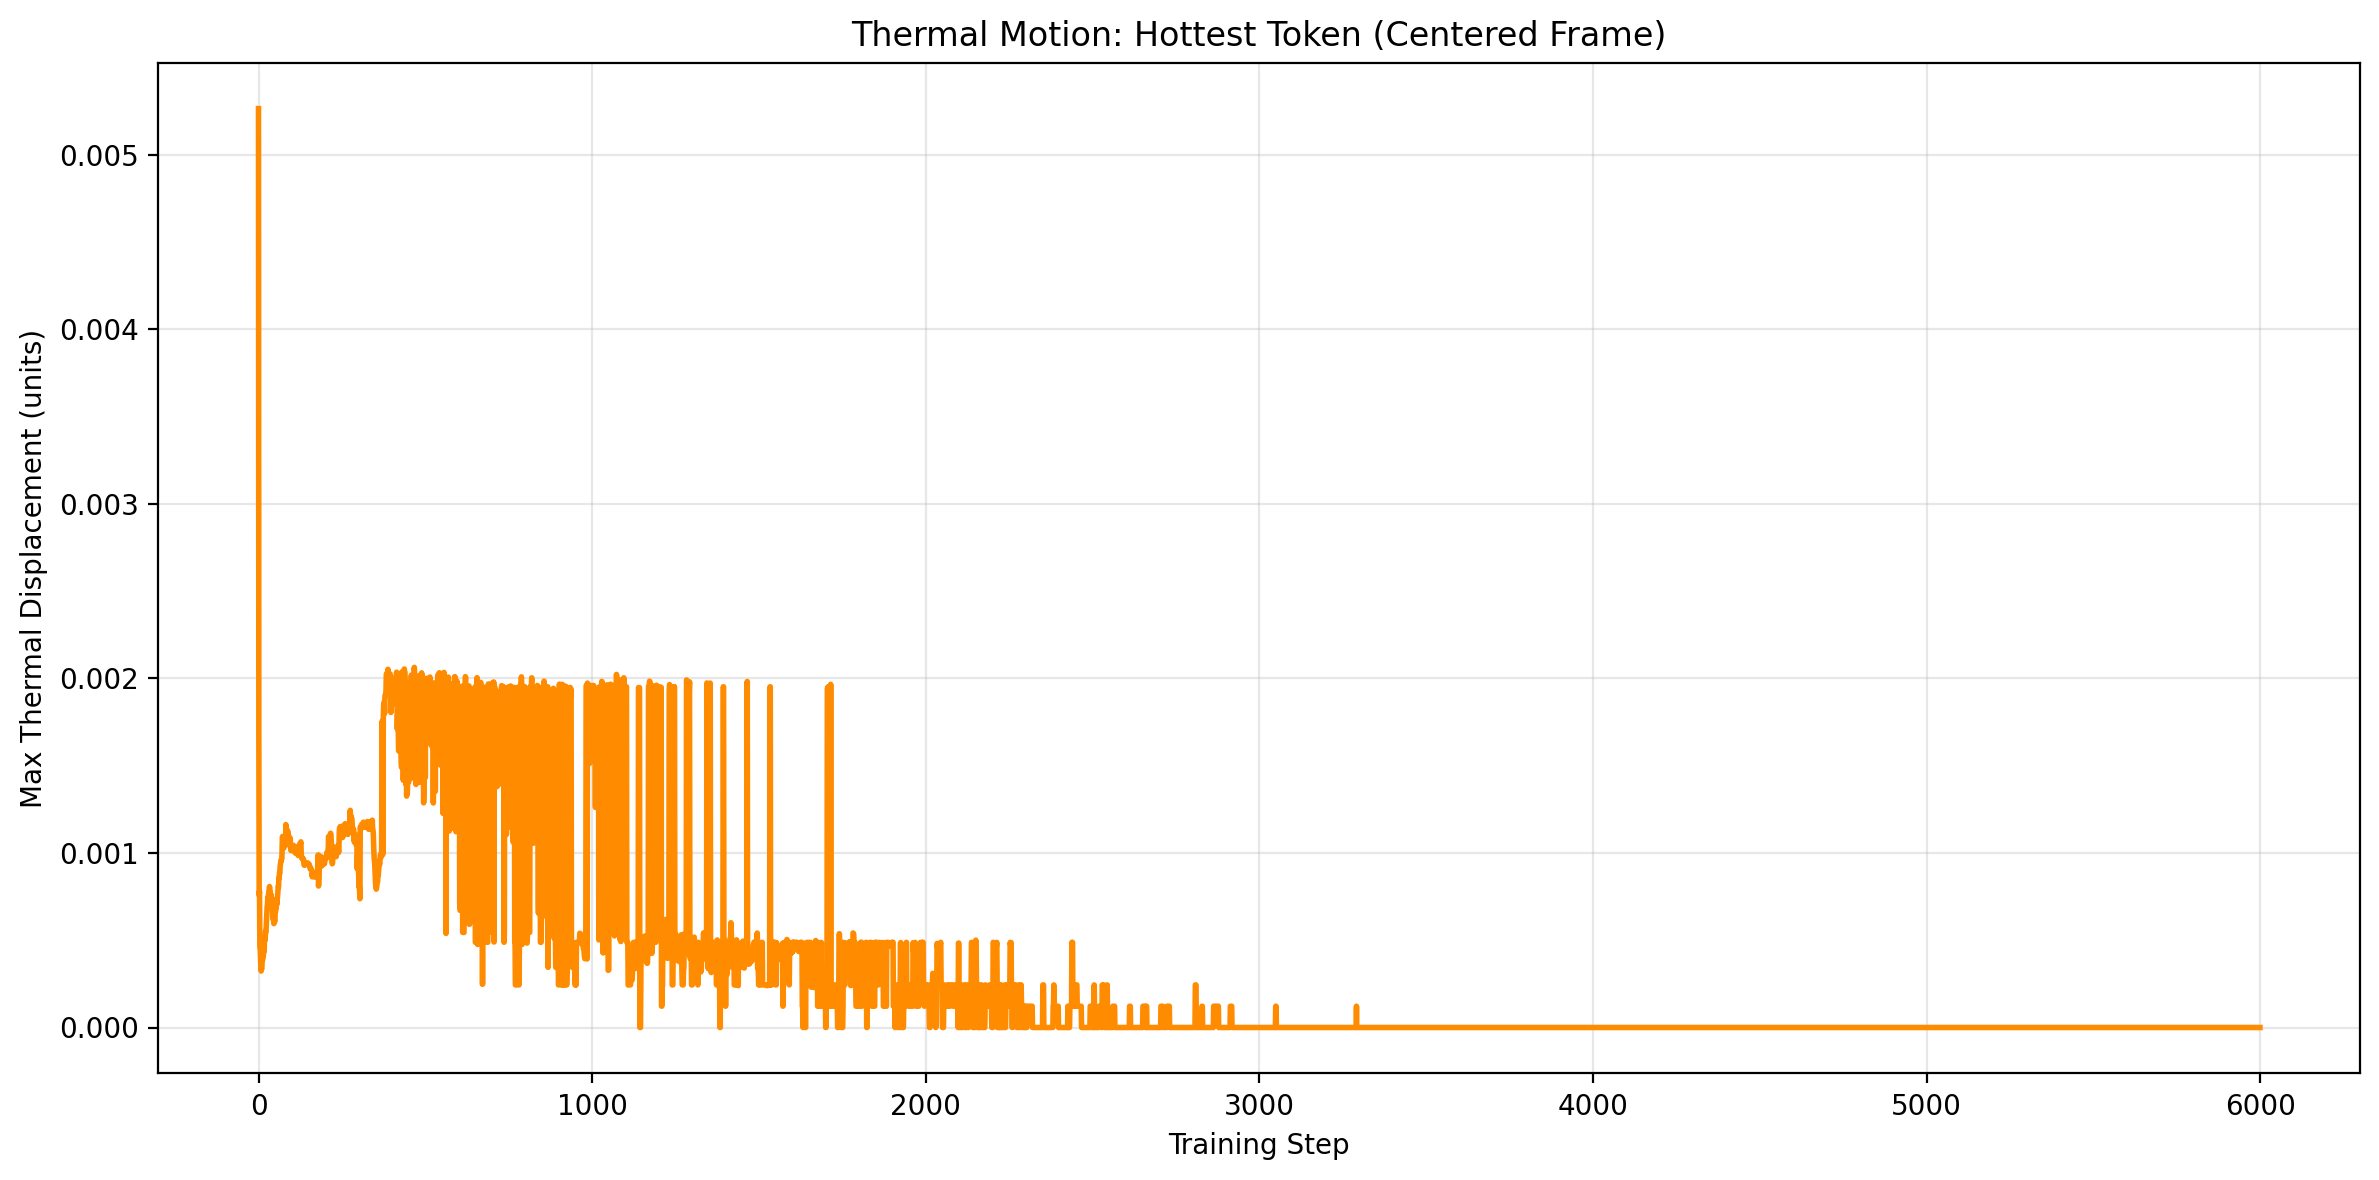


Interpretation: Largest single-token displacement relative to center of mass.


In [14]:
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

ax.plot(max_thermal_displacement.numpy(), linewidth=2, color='darkorange')

ax.set_xlabel('Training Step')
ax.set_ylabel('Max Thermal Displacement (units)')
ax.set_title('Thermal Motion: Hottest Token (Centered Frame)')
ax.set_yscale('linear')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretation: Largest single-token displacement relative to center of mass.")

## Comparison: Bulk vs. Thermal Motion

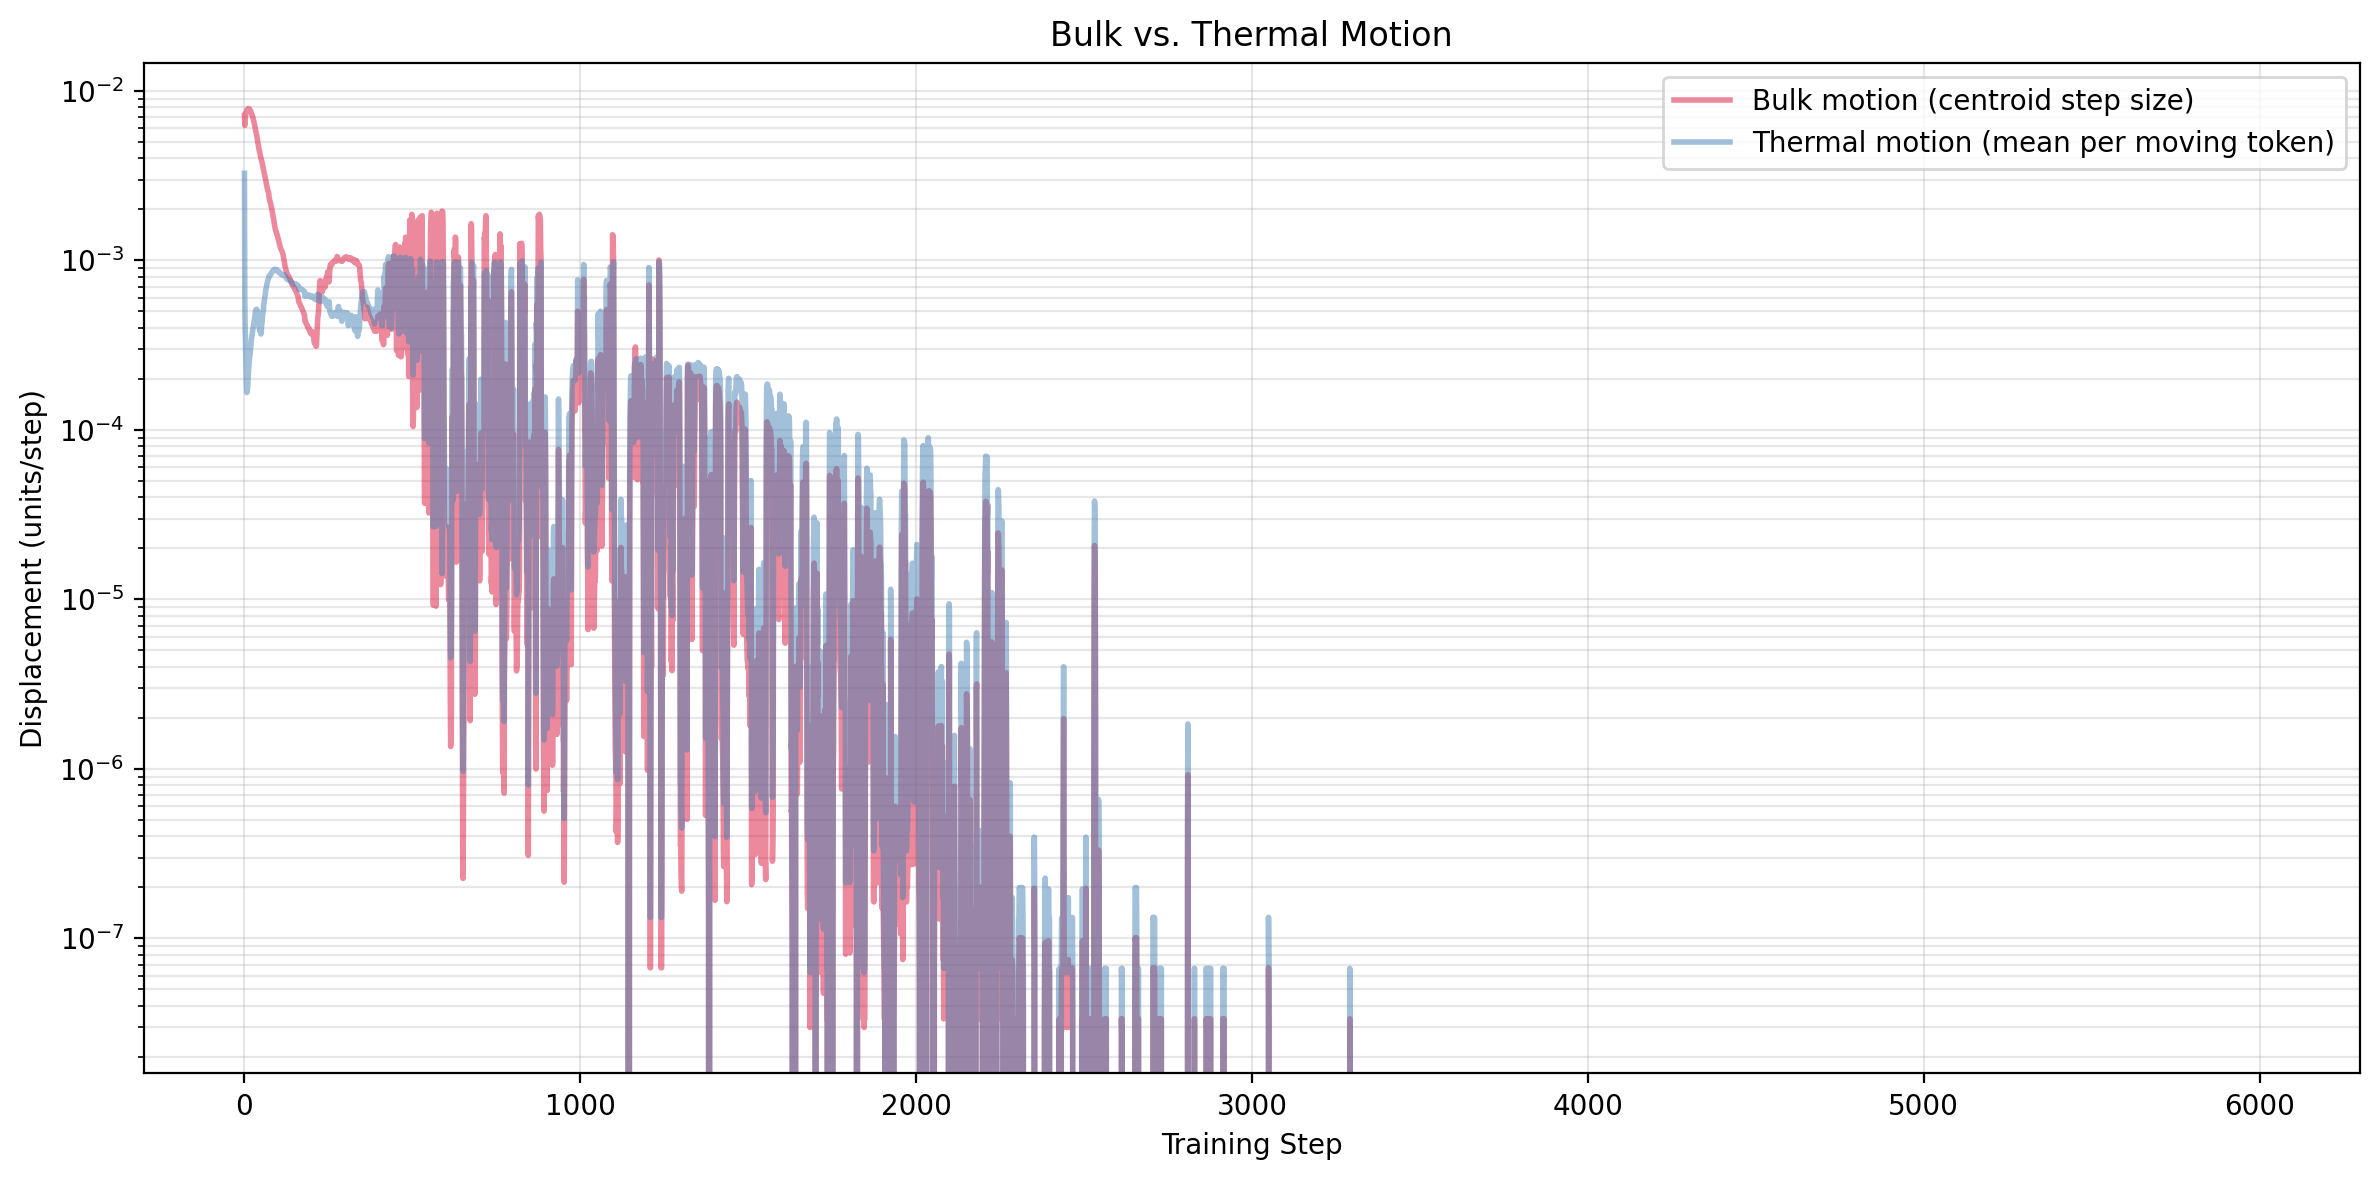


Interpretation: Which dominates—cloud drift or internal jitter?
  Bulk > thermal → cloud drifts faster than tokens jitter internally
  Thermal > bulk → internal motion dominates


In [15]:
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

# Centroid step size (bulk motion per step)
ax.plot(centroid_step_size.numpy(), linewidth=2, color='crimson', alpha=0.5,
        label='Bulk motion (centroid step size)')

# Mean thermal displacement per moving token
mean_thermal_per_token = total_thermal_L2 / (n_moving + 1e-10)
ax.plot(mean_thermal_per_token.numpy(), linewidth=2, color='steelblue', alpha=0.5,
        label='Thermal motion (mean per moving token)')

ax.set_xlabel('Training Step')
ax.set_ylabel('Displacement (units/step)')
ax.set_title('Bulk vs. Thermal Motion')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print("\nInterpretation: Which dominates—cloud drift or internal jitter?")
print("  Bulk > thermal → cloud drifts faster than tokens jitter internally")
print("  Thermal > bulk → internal motion dominates")

## Summary Statistics

In [16]:
print("\n" + "="*80)
print("BULK VS. THERMAL MOTION SUMMARY")
print("="*80 + "\n")

print("BULK MOTION (Centroid Trajectory):")
print("-" * 40)
print(f"  Total displacement: {total_displacement_magnitude:.6f} units")
print(f"  Bias magnitude: {bias_magnitude:.6e} units/step")
print(f"  Typical step size: {typical_step_size:.6e} units/step")
print(f"  Expected (unbiased RW): {expected_unbiased:.6f} units")
print(f"  Expected (pure bias): {expected_from_bias:.6f} units")
print(f"  Bias-to-noise ratio: {bias_to_noise:.2f}")

print("\nTHERMAL MOTION (Centered Frame):")
print("-" * 40)
print(f"  Total thermal displacement (t=0): {total_thermal_L2[0].item():.4f} units")
print(f"  Total thermal displacement (t=final): {total_thermal_L2[-1].item():.4e} units")
print(f"  Thermal KE analog (t=0): {thermal_KE_analog[0].item():.4e}")
print(f"  Thermal KE analog (t=final): {thermal_KE_analog[-1].item():.4e}")
print(f"  Max thermal displacement (t=0): {max_thermal_displacement[0].item():.6f} units")
print(f"  Max thermal displacement (t=final): {max_thermal_displacement[-1].item():.6e} units")

print("\nDECAY FACTORS (final / initial):")
print("-" * 40)
if total_thermal_L2[0] > 0:
    thermal_decay = total_thermal_L2[-1] / total_thermal_L2[0]
    print(f"  Thermal L2: {thermal_decay:.2e}")
if thermal_KE_analog[0] > 0:
    thermal_KE_decay = thermal_KE_analog[-1] / thermal_KE_analog[0]
    print(f"  Thermal KE: {thermal_KE_decay:.2e}")

print("\n" + "="*80)
print("✓ Bulk vs. thermal motion analysis complete.")
print("="*80)


BULK VS. THERMAL MOTION SUMMARY

BULK MOTION (Centroid Trajectory):
----------------------------------------
  Total displacement: 0.701211 units
  Bias magnitude: 1.168685e-04 units/step
  Typical step size: 3.194245e-05 units/step
  Expected (unbiased RW): 0.019794 units
  Expected (pure bias): 0.701211 units
  Bias-to-noise ratio: 35.43

THERMAL MOTION (Centered Frame):
----------------------------------------
  Total thermal displacement (t=0): 12.0821 units
  Total thermal displacement (t=final): 0.0000e+00 units
  Thermal KE analog (t=0): 2.0102e-02
  Thermal KE analog (t=final): 0.0000e+00
  Max thermal displacement (t=0): 0.005266 units
  Max thermal displacement (t=final): 0.000000e+00 units

DECAY FACTORS (final / initial):
----------------------------------------
  Thermal L2: 0.00e+00
  Thermal KE: 0.00e+00

✓ Bulk vs. thermal motion analysis complete.
